1. ПРЕДОБРАБОТКА.

In [40]:
from help import *
from plot import * 
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# from skopt.space import Integer, Real, Categorical
# from skopt import BayesSearchCV

In [3]:
SEED = 52
df = pd.read_csv('boston.csv')
X, y = divide_data(df, 'MEDV')
preprocessor = Pipeline([
    ('identity', FunctionTransformer())
])
preprocessor.set_output(transform="pandas")

Pipeline(steps=[('identity', FunctionTransformer())])

In [5]:
#Создаем PolyFeatures
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
numerical_cols = X.columns.drop('CHAS')
categorical_cols = ['CHAS']
poly_features = poly.fit_transform(X[numerical_cols])

# Получаем имена новых признаков
poly_feature_names = poly.get_feature_names_out(numerical_cols)

# Создаем DataFrame с полиномиальными признаками
X_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

# Добавляем бинарный признак без изменений 
X_poly[categorical_cols] = df[categorical_cols]
len(X_poly.columns), len(numerical_cols)


(91, 12)

2.1 GridSearchCV

In [70]:
base_model = XGBRegressor(random_state = SEED)

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

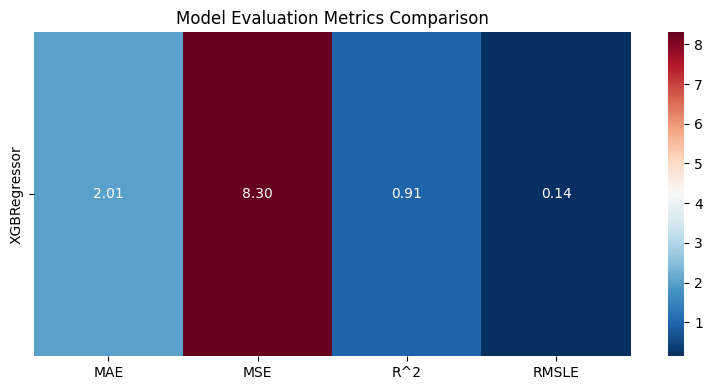

,MAE,MSE,R^2,RMSLE
XGBRegressor,2.009491,8.304497,0.912896,0.142095


In [32]:
initial_metrics = train_evaluate_models(
    models=[('XGBRegressor', XGBRegressor())],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)
initial_metrics

Получаем достаточно высокий baseline показатель R^2, но для такого обилия признаков нужна регуляризация.

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


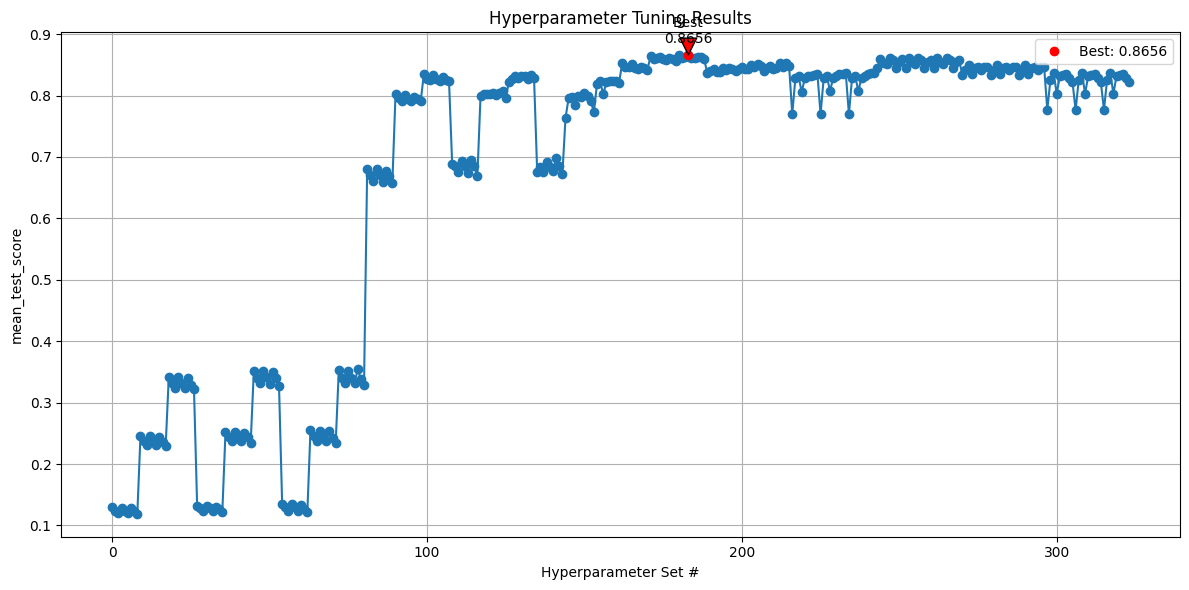

In [15]:
import time
import warnings

warnings.filterwarnings("ignore")

base_model = XGBRegressor(random_state = SEED)
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


param_grid = {
    'reg_alpha': [0, 0.5, 2.0],
    'reg_lambda': [0.1, 1.0, 2.0],
    'learning_rate': [0.001, 0.01, 0.05, 0.3],
    'max_depth': [3, 5, 10],
    'n_estimators': [100, 200, 300]
}


grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='r2',
    n_jobs=-1,
    cv=cv,
    verbose = 1
)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = SEED) 

grid_search_start = time.time()
grid_search.fit(X_train, y_train)
grid_search_end = time.time()
data = plot_hyperparam_search_results(grid_search.cv_results_, xtick_step=100)

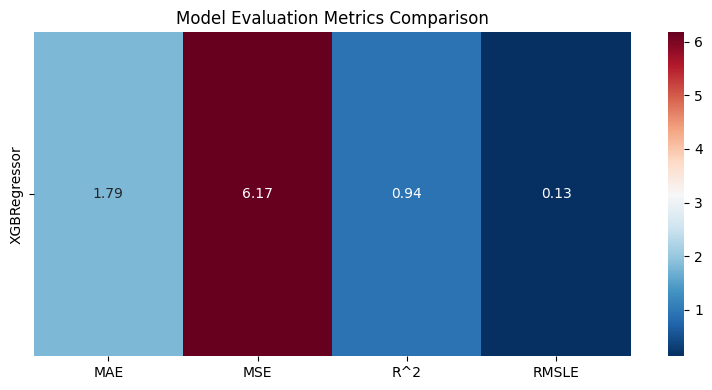

,MAE,MSE,R^2,RMSLE
XGBRegressor,1.790451,6.172976,0.935253,0.13497


In [69]:
grid_metrics = train_evaluate_models(
    models=[('XGBRegressor', grid_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)
grid_metrics

In [76]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 300,
 'reg_alpha': 0.5,
 'reg_lambda': 0.1}

(<Figure size 800x400 with 2 Axes>,
                   MAE       MSE       R^2     RMSLE
 XGBRegressor -0.21904 -2.131521  0.022357 -0.007125)

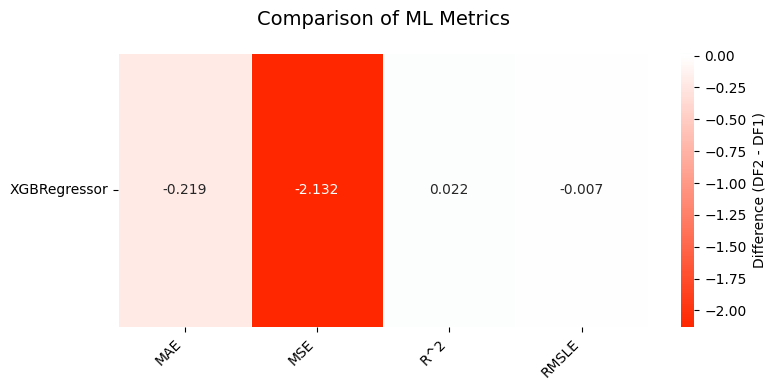

In [55]:
compare_metrics_heatmap(initial_metrics, grid_metrics)

Отличная прибавка! 

2.2 RANDOMIZED SEARCH

In [75]:
np.random.uniform(0,10), np.random.randint(5,10,20)

(8.528412270511692,
 array([6, 5, 9, 7, 5, 8, 8, 7, 9, 5, 8, 9, 9, 9, 7, 7, 5, 6, 7, 5]))

In [79]:
param_dist =  {
    'reg_alpha': np.random.uniform(0,2,2),
    'reg_lambda': np.random.uniform(0,3,2),
    'learning_rate': [0.001, 0.05, 0.2],
    'max_depth': [3, 5, 10],
    'n_estimators': [200, 300]
}

In [83]:
randomized_search = RandomizedSearchCV(
    random_state=SEED,
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='r2',
    cv=cv,
    n_jobs=1,
    verbose=2
)

In [84]:
randomized_search_start = time.time()
randomized_search.fit(X_train, y_train)
randomized_search_end = time.time()

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.3s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.9s
[CV] END learning_rate=0.001, max_depth=3, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=200, reg_alpha=0.8847713999074949, reg_lambda=1.8714137352365596; total time=   0.5s
[CV] END learning_rate=0.2, max_depth=10, n_estimators=200, reg_alpha=0.8847713999074949, reg

In [88]:
randomized_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=52, ...)

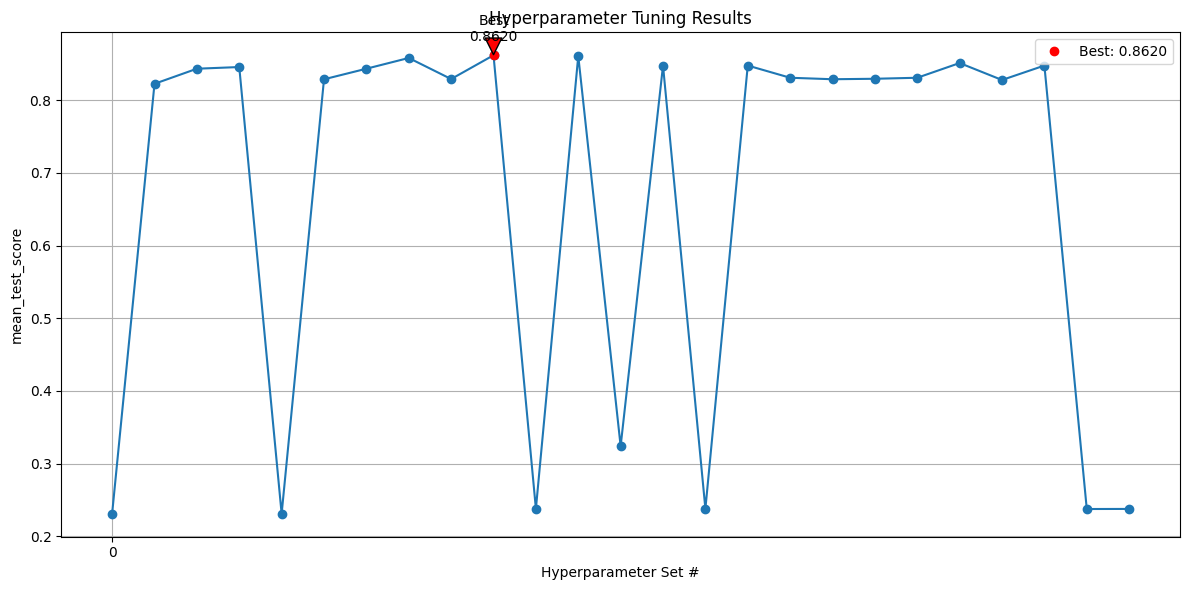

In [91]:
data = plot_hyperparam_search_results(randomized_search.cv_results_, xtick_step=100)

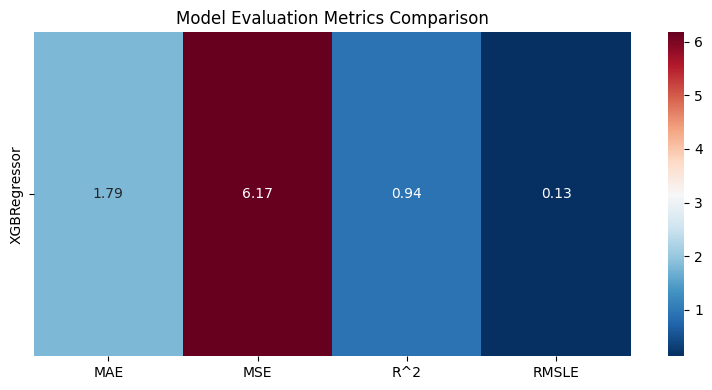

,MAE,MSE,R^2,RMSLE
XGBRegressor,1.790451,6.172976,0.935253,0.13497


In [85]:
random_grid_metrics = train_evaluate_models(
    models=[('XGBRegressor', grid_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)
random_grid_metrics

(<Figure size 800x400 with 2 Axes>,
               MAE  MSE  R^2  RMSLE
 XGBRegressor  0.0  0.0  0.0    0.0)

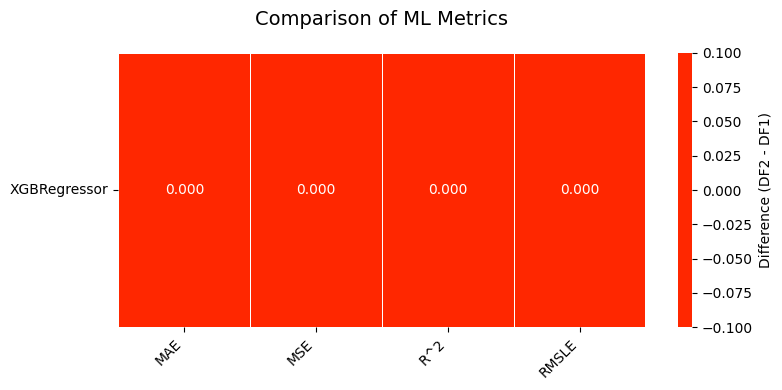

In [90]:
compare_metrics_heatmap(grid_metrics, random_grid_metrics)

Можно значительно быстрее попасть на оптимальный эстиматор, но есть риск не попасть вообще!

2.3 BAYESIAN SEARCH

In [ ]:
# !pip install scikit-optimize
# from skopt.space import Integer, Real



ModuleNotFoundError: No module named 'skopt'